In [1]:
import os
import warnings
import pandas as pd
import numpy as np
from pathlib import Path
from tqdm import tqdm
import anndata as ad
import lightning as L
import lamindb as ln
import matplotlib.pyplot as plt
import scanpy as sc
from sklearn.metrics import average_precision_score
import torch

from modlyn.io.loading import read_lazy
from modlyn.io.datamodules import ClassificationDataModule
from modlyn.models.linear import Linear

# Start tracking
# ln.track(project="Modlyn")
project = ln.Project(name="Modlyn")
project.save()

ln.track(project="Modlyn")

# Load data
store_path = Path("/home/ubuntu/tahoe100M_chunk_1")
adata = read_lazy(store_path)
var = pd.read_parquet("var_subset_tahoe100M.parquet")
adata.var = var
adata.obs["y"] = adata.obs["cell_line"].astype("category").cat.codes.astype("i8")

# Subset
adata_train = adata[:80000]
adata_val = adata[80000:100000]


→ connected lamindb: laminlabs/arrayloader-benchmarks
→ returning existing Project record with same name: 'Modlyn'


→ loaded Transform('gNsLqUL4vNwU0000'), re-started Run('DQrZNswi...') at 2025-07-02 22:04:17 UTC
→ notebook imports: anndata==0.12.0rc3 lamindb==1.5.3 lightning==2.5.1.post0 matplotlib==3.10.3 modlyn==0.0.2 numpy==2.2.6 pandas==2.2.3 scanpy==1.11.2 scikit-learn==1.6.1 scipy==1.14.1 statsmodels==0.14.4 torch==2.7.0 tqdm==4.67.1
• recommendation: to identify the notebook across renames, pass the uid: ln.track("gNsLqUL4vNwU", project="Modlyn")


/home/ubuntu/conda/envs/lamin_env/lib/python3.12/site-packages/zarr/codecs/vlen_utf8.py:44: UserWarning: The codec `vlen-utf8` is currently not part in the Zarr format 3 specification. It may not be supported by other zarr implementations and may change in the future.
  return cls(**configuration_parsed)
/home/ubuntu/conda/envs/lamin_env/lib/python3.12/site-packages/zarr/codecs/vlen_utf8.py:44: UserWarning: The codec `vlen-utf8` is currently not part in the Zarr format 3 specification. It may not be supported by other zarr implementations and may change in the future.
  return cls(**configuration_parsed)
/home/ubuntu/conda/envs/lamin_env/lib/python3.12/site-packages/zarr/codecs/vlen_utf8.py:44: UserWarning: The codec `vlen-utf8` is currently not part in the Zarr format 3 specification. It may not be supported by other zarr implementations and may change in the future.
  return cls(**configuration_parsed)
/home/ubuntu/conda/envs/lamin_env/lib/python3.12/site-packages/zarr/codecs/vlen_ut

In [2]:
datamodule = ClassificationDataModule(
    adata_train=adata_train,
    adata_val=adata_val,
    label_column="y",
    train_dataloader_kwargs={"batch_size": 2048, "drop_last": True},
    val_dataloader_kwargs={"batch_size": 2048, "drop_last": False},
)

linear = Linear(
    n_genes=adata.n_vars,
    n_covariates=adata.obs["y"].nunique(),
    learning_rate=1e-2,
)

trainer = L.Trainer(max_epochs=3, log_every_n_steps=100, max_steps=3000)
trainer.fit(linear, datamodule)


Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name          | Type             | Params | Mode 
-----------------------------------------------------------
0 | linear        | Linear           | 958 K  | train
1 | train_metrics | MetricCollection | 0      | train
2 | val_metrics   | MetricCollection | 0      | train
-----------------------------------------------------------
958 K     Trainable params
0         Non-trainable params
958 K     Total params
3.836     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode


Sanity Checking: |                                                | 0/? [00:00<?, ?it/s]

/home/ubuntu/conda/envs/lamin_env/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.
/home/ubuntu/conda/envs/lamin_env/lib/python3.12/site-packages/lightning/pytorch/utilities/data.py:123: Your `IterableDataset` has `__len__` defined. In combination with multi-process data loading (when num_workers > 1), `__len__` could be inaccurate if each worker is not configured independently to avoid having duplicate data.


/home/ubuntu/conda/envs/lamin_env/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.
/home/ubuntu/conda/envs/lamin_env/lib/python3.12/site-packages/lightning/pytorch/loops/fit_loop.py:310: The number of training batches (39) is smaller than the logging interval Trainer(log_every_n_steps=100). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Epoch 0: 100%|████████████████████████████████| 39/39 [00:13<00:00,  2.93it/s, v_num=54]
Validation: |                                                     | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|████████████████████████████████| 39/39 [00:13<00:00,  2.87it/s, v_num=54]
Validation: |                                                     | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|████████████████████████████████| 39/39 [00:13<00:00,  2.89it/s, v_num=54]
Validation: |                                                     | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|████████████████████████████████| 39/39 [00:16<00:00,  2.33it/s, v_num=54]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 2: 100%|████████████████████████████████| 39/39 [00:16<00:00,  2.33it/s, v_num=54]


In [3]:
weights = linear.linear.weight.detach().cpu().numpy()
weights_df = pd.DataFrame(
    weights, 
    columns=adata.var_names,
    index=[f"cell_line_{i}" for i in range(weights.shape[0])]
)

top_genes_per_cellline = {}
for i, cell_line in enumerate(weights_df.index):
    top_genes = weights_df.loc[cell_line].nlargest(20)
    top_genes_per_cellline[cell_line] = top_genes

# weights_df.to_csv("modlyn_cell_line_signatures.csv")
weights

array([[ 0.01617639, -0.0104503 , -0.01781774, ..., -0.00466566,
         0.08008608,  0.05188204],
       [ 0.17788002, -0.02562691, -0.06655379, ..., -0.00065606,
         0.04699329,  0.07442127],
       [-0.01704808, -0.14699498,  0.000988  , ..., -0.0508051 ,
         0.07240915, -0.02790339],
       ...,
       [-0.04828951,  0.00111578, -0.0305419 , ..., -0.00617025,
        -0.03792496, -0.03348325],
       [-0.02957912, -0.05883463,  0.04737902, ...,  0.00081202,
        -0.022748  ,  0.03103777],
       [ 0.08913242,  0.00354651,  0.0248891 , ..., -0.00152876,
        -0.02045342,  0.06125364]], shape=(50, 19177), dtype=float32)

['IGFBP4', 'IGSF1', 'ADGRG7', 'ADPRM', 'WDR72', 'RETSAT', 'PTN', 'DNAH8', 'CCDC152', 'FYB1', 'DNAJC22', 'MGAT4B', 'CD33', 'RNF17', 'KRT81']


/tmp/ipykernel_252105/3861412143.py:26: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


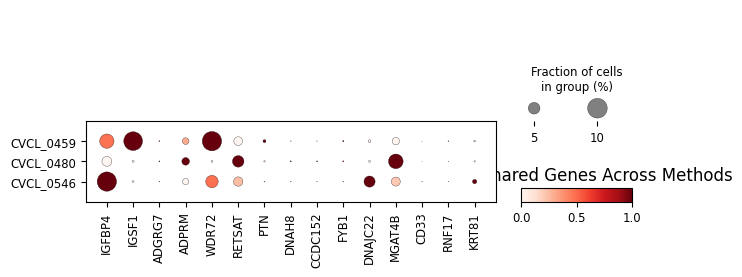

In [4]:
top_cell_lines = adata.obs["cell_line"].value_counts().index[:3].tolist()

# # Subset data
adata_subset = adata[adata.obs["cell_line"].isin(top_cell_lines)].copy()

cell_lines = list(top_genes_per_cellline.keys())[:3]

# Get intersection of top 10 genes across the 3
top_sets = [set(top_genes_per_cellline[cl].index[:10]) for cl in cell_lines]
shared_genes = list(set.intersection(*top_sets))
if not shared_genes:
    shared_genes = list(set.union(*[set(top_genes_per_cellline[cl].index[:5]) for cl in cell_lines]))

print(shared_genes)

# Plot
sc.pl.dotplot(
    adata_subset,
    var_names=shared_genes,
    groupby="cell_line",
    standard_scale="var",
    dendrogram=False,
    show=False
)
plt.title("Top 10 Shared Genes Across Methods")
plt.tight_layout()
# plt.savefig("shared_dotplot.pdf")


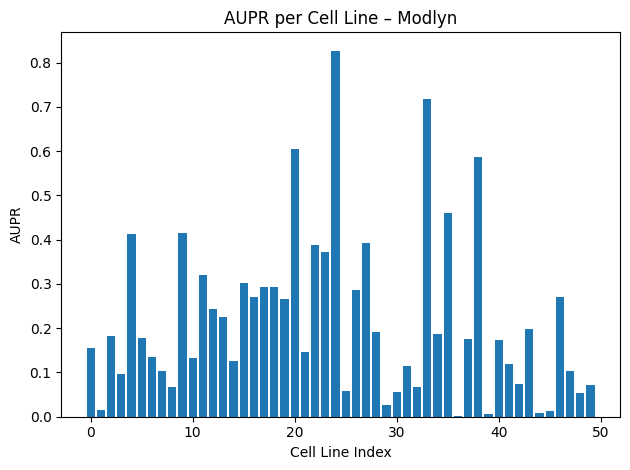

In [5]:
# Predict on validation set
preds = []
linear.eval()
for batch in datamodule.val_dataloader():
    x, y = batch
    with torch.no_grad():
        preds.append(linear(x).detach().cpu().numpy())

y_score = np.vstack(preds)
y_true = adata_val.obs["y"].values

# Compute AUPR per class
aupr_scores = []
for i in range(y_score.shape[1]):
    y_bin = (y_true == i).astype(int)
    aupr = average_precision_score(y_bin, y_score[:, i])
    aupr_scores.append(aupr)

# Plot AUPR
plt.figure()
plt.bar(range(len(aupr_scores)), aupr_scores)
plt.xlabel("Cell Line Index")
plt.ylabel("AUPR")
plt.title("AUPR per Cell Line – Modlyn")
plt.tight_layout()
# plt.savefig("modlyn_aupr.pdf")


1. Uncertainty-Aware Dotplots
A plot where:

Dot size = uncertainty (e.g. inverse of standard error),

Dot color = effect size (e.g. logistic regression weight),
similar to Scanpy/Seurat dotplots or volcano plots7d994388-c1d5-41d7-ba15….

Comparison Metrics Across Methods

2. Correlation metrics like Kendall's Tau or Spearman's rho to quantify agreement between:

Logistic regression weights (Modlyn)

Wilcoxon test statistics

Scanpy logistic regression results7d994388-c1d5-41d7-ba15…7330e61d-cefc-472f-a73a…

3. Differential Expression Testing Benchmark

Use sc.tl.rank_genes_groups() (Wilcoxon) as a reference.

Compare results with:

LogReg-derived weights using t-test-style criteria

Associated uncertainty estimates7d994388-c1d5-41d7-ba15…7330e61d-cefc-472f-a73a…

4. Scale Testing on Small Dataset

Run this script: https://lamin.ai/laminlabs/arrayloader-benchmarks/transform/mVi9vDOMcgir on a small dataset to validate methodology before full scale7d994388-c1d5-41d7-ba15….

5. Visual Comparison Figure (Figure 1 Style)
A 3-panel figure:

Left: Bulk average expression dotplot

Middle: Dotplot from Wilcoxon

Right: Dotplot from logistic regression with uncertainty (Modlyn)


TODO: Felix: 1M, 10M, 100M datasets

TODO: Subsampled version: Make one 1M cells test dataset

scanpy reproduction and multinomial logistic regression for now they can get some interpretations out of these data better scvi and limma


sklearn for ligistic regression or 

In [6]:
weights = linear.linear.weight.detach().cpu().numpy()
weights_df = pd.DataFrame(
    weights, 
    columns=adata.var_names,
    index=[f"cell_line_{i}" for i in range(weights.shape[0])]
)

top_genes_per_cellline = {}
for i, cell_line in enumerate(weights_df.index):
    top_genes = weights_df.loc[cell_line].nlargest(20)
    top_genes_per_cellline[cell_line] = top_genes

top_cell_lines = adata.obs["cell_line"].value_counts().index[:3].tolist()
adata_subset = adata[adata.obs["cell_line"].isin(top_cell_lines)].copy()

cell_lines = list(top_genes_per_cellline.keys())[:3]

# Get shared genes
top_sets = [set(top_genes_per_cellline[cl].index[:10]) for cl in cell_lines]
shared_genes = list(set.intersection(*top_sets))
if not shared_genes:
    shared_genes = list(set.union(*[set(top_genes_per_cellline[cl].index[:5]) for cl in cell_lines]))

print(f"Analyzing {len(shared_genes)} shared genes")

Analyzing 15 shared genes


In [ ]:
import seaborn as sns
from matplotlib import cm

# Compute Fisher Information Matrix (diagonal approximation)
def compute_fisher_info_and_se(model, dataloader):
    model.eval()
    fisher_diag = torch.zeros_like(model.linear.weight)

    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Computing Fisher Information"):
            x, y = batch
            logits = model.linear(x)
            probs = torch.softmax(logits, dim=1)

            for i in range(probs.shape[1]):
                p = probs[:, i].unsqueeze(1)
                fisher_i = p * (1 - p) * x**2
                fisher_diag[i] += fisher_i.sum(dim=0)

    se = torch.sqrt(1.0 / (fisher_diag + 1e-8))  # Add epsilon for numerical stability
    confidence = 1.0 / se**2
    return se.cpu().numpy(), confidence.cpu().numpy()

se, confidence = compute_fisher_info_and_se(linear, datamodule.val_dataloader())
confidence_df = pd.DataFrame(
    confidence,
    columns=adata.var_names,
    index=[f"cell_line_{i}" for i in range(confidence.shape[0])]
)

In [86]:
# conf_scaled.values.round(3)
weights_sub.max()

gene_name
RIMBP2             0.205711
UTY                0.238616
NKAIN3             0.241786
GOLGA8O            0.057363
CBARP              0.142768
CCDC116            0.162608
CIART              0.205044
SYNE4              0.098975
MAGEH1             0.123940
ADGRD1             0.156871
TEX22              0.197221
ELN                0.125330
STC1               0.233030
HLA-DOA            0.184821
C9orf50            0.119432
NPAS1              0.268859
SLC10A3            0.171592
MZB1               0.154905
HRH1               0.267428
ILDR2              0.155966
MTLN               0.141034
OR13A1             0.092105
TNFSF12-TNFSF13    0.064172
MSC                0.219206
FXYD2              0.249495
FCGBP              0.212763
SLC14A1            0.224888
GATA2              0.213466
PAGE5              0.228208
HTR2B              0.057054
MROH2B             0.112428
RAB5B              0.251253
BCL11A             0.181453
SLC34A2            0.228461
SLC22A16           0.116553
KLK7      

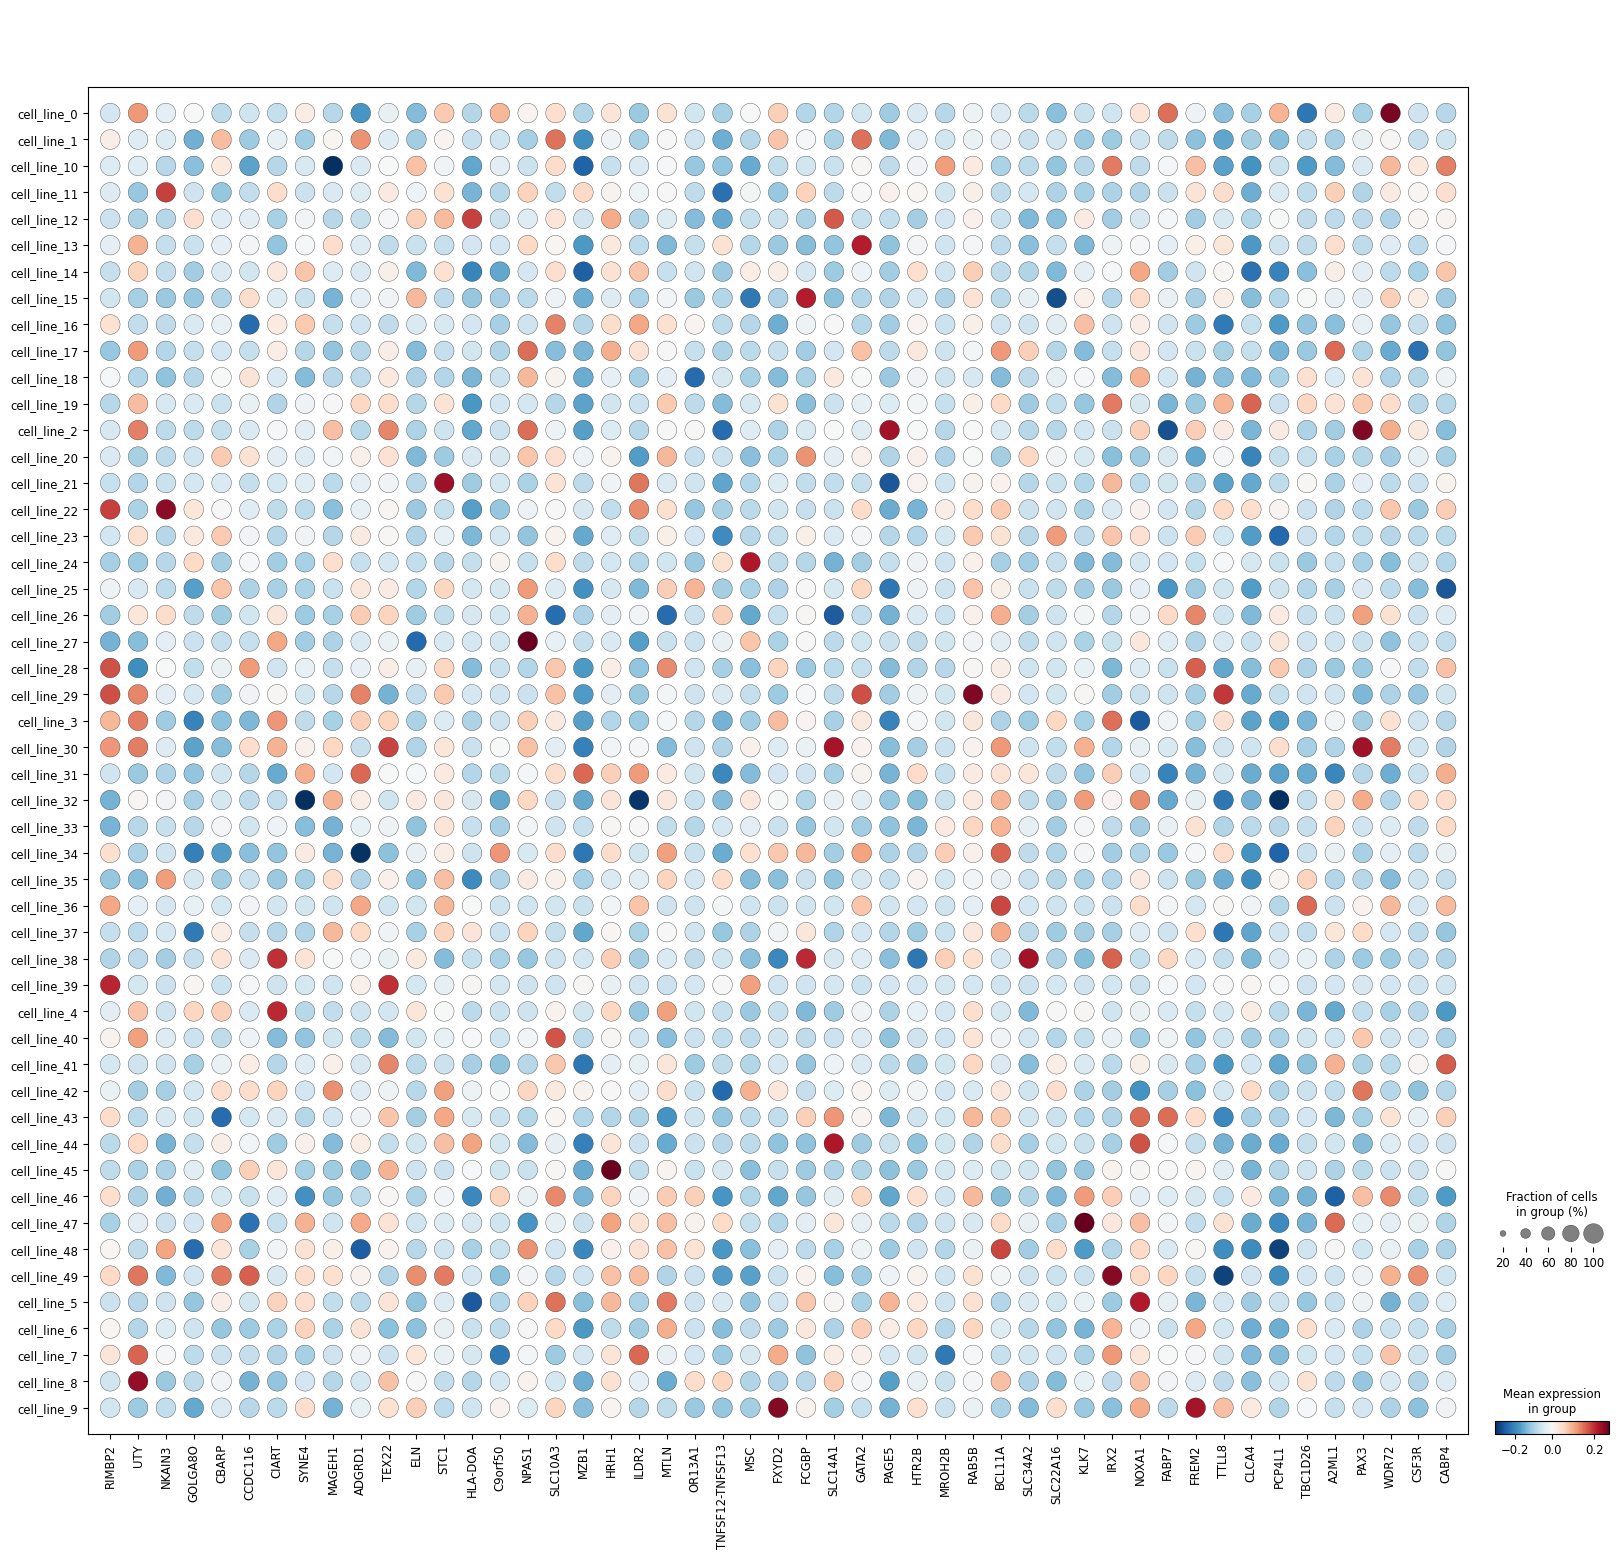

In [92]:
from anndata import AnnData
from sklearn.preprocessing import minmax_scale
import numpy as np
import pandas as pd
import scanpy as sc

# Select top genes (you can modify this list or use shared genes instead)
top_genes = list({gene for genes in top_genes_per_cellline.values() for gene in genes.index})[1:50]

# Subset weights and confidence matrices
weights_sub = weights_df[top_genes]
confidence_sub = confidence_df[top_genes]
# print(weights_sub.head())

# Clip high confidence outliers (optional but helps visibility)
conf_clipped = np.clip(confidence_sub, 0, np.percentile(confidence_sub, 99))

# Min-max scale confidence row-wise to simulate expression fractions
conf_scaled = pd.DataFrame(
    minmax_scale(conf_clipped, axis=1),
    index=confidence_sub.index,
    columns=confidence_sub.columns
)

# Build AnnData: .X = confidence → controls dot size
adata_dot = AnnData(
    X=conf_scaled.values,
    obs=pd.DataFrame(index=conf_scaled.index),
    var=pd.DataFrame(index=conf_scaled.columns)
)

# Add group labels for Scanpy to use
adata_dot.obs["cell_line"] = conf_scaled.index
adata_dot.obs_names = conf_scaled.index
adata_dot.var_names = conf_scaled.columns

# Add weights (effect sizes) as color layer
adata_dot.layers["weights"] = weights_sub.loc[adata_dot.obs_names, adata_dot.var_names].values

# Plot: size from .X (confidence), color from weights layer
sc.pl.dotplot(
    adata=adata_dot,
    var_names=adata_dot.var_names.tolist(), 
    groupby="cell_line",
    use_raw=False,
    layer="weights",  # color: logistic regression weights
    # title="Uncertainty-Aware DotPlot (Color = Effect Size, Size = Confidence)",
    # colorbar_title="Effect Size (Weight)",
    cmap="RdBu_r",
    vcenter=0.0, #vmax = , vmin = ,
    expression_cutoff=-2,  # show all values
    # dot_min=0.01,
    # dot_max=0.3,
    # smallest_dot=1.0,  # ensures small dots are visible
    # standard_scale=None,
    # mean_only_expressed=False,
    show=True
)


In [15]:
adata_dot

AnnData object with n_obs × n_vars = 50 × 842
    obs: 'cell_line'
    layers: 'conf'

In [54]:
import warnings
warnings.filterwarnings('ignore')

import statsmodels.api as sm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scanpy as sc

# 1. Pick the top 3 real cell‐lines by count
cell_lines = adata.obs["cell_line"].value_counts().index[:3].tolist()

cats = adata.obs["cell_line"].astype("category").cat.categories
label_to_code = {lbl: i for i, lbl in enumerate(cats)}
top_genes_per_cellline = {
    cl: weights_df.loc[f"cell_line_{label_to_code[cl]}"]
             .nlargest(20).index.tolist()
    for cl in cell_lines
}
top_sets = [set(top_genes_per_cellline[cl][:10]) for cl in cell_lines]
shared_genes = list(set.intersection(*top_sets)) or list(set.union(*top_sets))

# 3. Run Scanpy’s logistic‐regression & Wilcoxon tests
sc.tl.rank_genes_groups(adata_train,
                        groupby="cell_line",
                        method="logreg",
                        key_added="rank_logreg")
sc.tl.rank_genes_groups(adata_train,
                        groupby="cell_line",
                        method="wilcoxon",
                        key_added="rank_wilcoxon")



In [57]:
# 4. Gather effect_size & uncertainty for each method × cell_line × gene
records = []
for method, key in [("Scanpy LogReg", "rank_logreg"),
                    ("Wilcoxon",    "rank_wilcoxon")]:
    for cl in cell_lines:
        df = sc.get.rank_genes_groups_df(adata_train, group=cl, key=key)
        df = df[df["names"].isin(shared_genes)]

        # use available columns
        available_cols = df.columns
        if "pvals_adj" in available_cols:
            pvals = df["pvals_adj"]
        elif "pvals" in available_cols:
            pvals = df["pvals"]
        else:
            pvals = pd.Series([1.0] * len(df), index=df.index)  # fallback

        for (_, row), pval in zip(df.iterrows(), pvals):
            records.append({
                "method":       method,
                "cell_line":    cl,
                "gene":         row["names"],
                "effect_size":  row["scores"],
                "uncertainty":  -np.log10(pval + 1e-300),
            })


In [59]:
# records

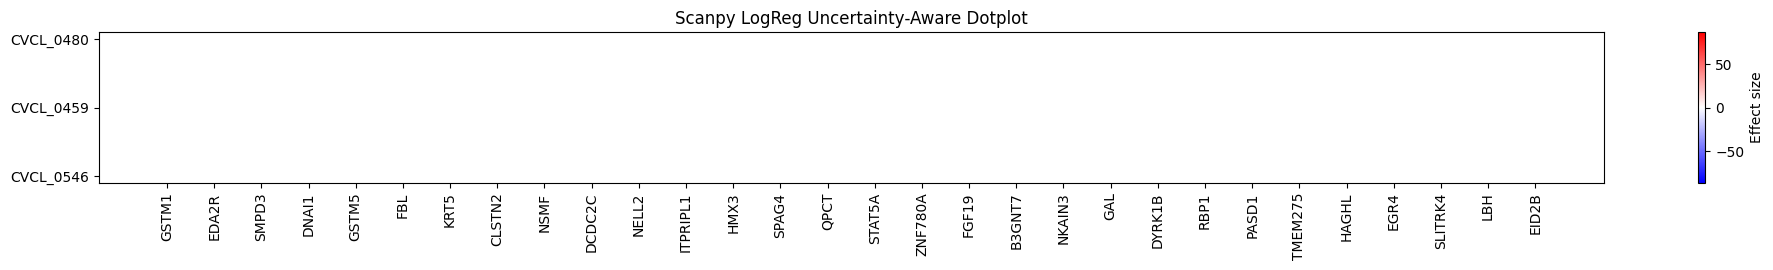

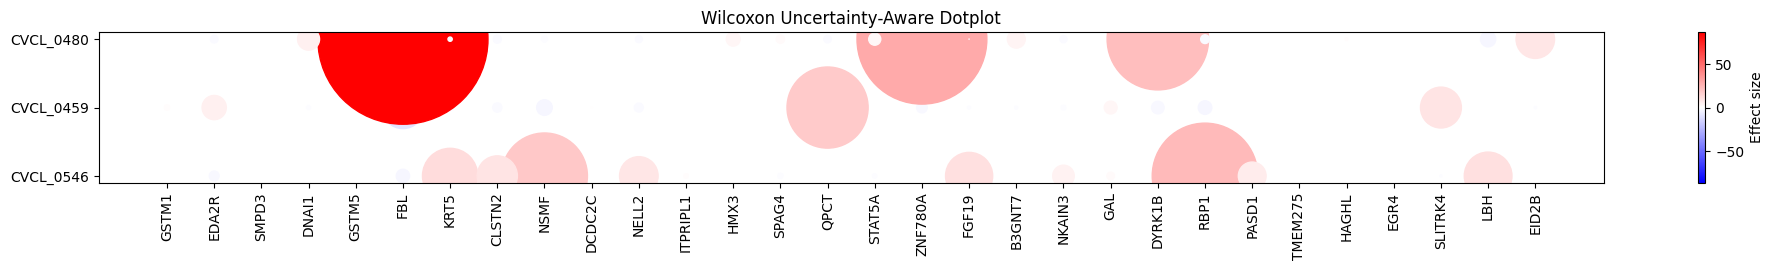

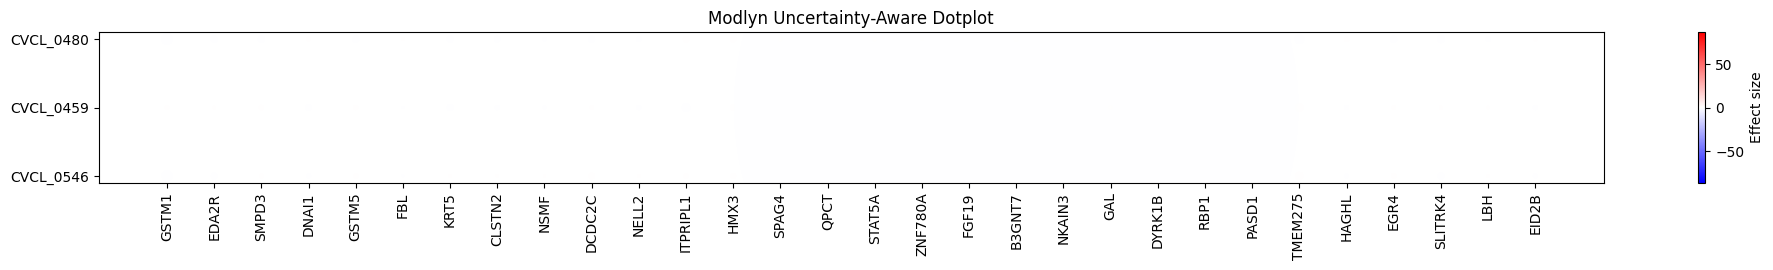

In [60]:
# 5. Compute Modlyn’s uncertainties via small Logit fits on shared_genes
gene_idx = [adata.var_names.get_loc(g) for g in shared_genes]
X = adata_train.X[:, gene_idx]
if hasattr(X, "toarray"):
    X = X.toarray()

for cl in cell_lines:
    code      = label_to_code[cl]
    row_label = f"cell_line_{code}"
    y_bin     = (adata_train.obs["cell_line"] == cl).astype(int).values
    Xc        = sm.add_constant(X)
    res       = sm.Logit(y_bin, Xc).fit(disp=False)
    for j, gene in enumerate(shared_genes):
        records.append({
            "method":       "Modlyn",
            "cell_line":    cl,
            "gene":         gene,
            "effect_size":  weights_df.loc[row_label, gene],
            "uncertainty":  res.bse[j+1],  # stderr of coefficient j
        })

metrics = pd.DataFrame.from_records(records)

# 6. Draw Uncertainty‐Aware Dotplots
vmax = metrics["effect_size"].abs().max()
for method in ["Scanpy LogReg", "Wilcoxon", "Modlyn"]:
    dfm = metrics[metrics["method"] == method]
    fig, ax = plt.subplots(figsize=(len(shared_genes)*0.6 + 2,
                                   len(cell_lines)*0.6 + 1))
    for cl in cell_lines:
        dfn = dfm[dfm["cell_line"] == cl]
        xs  = [shared_genes.index(g) for g in dfn["gene"]]
        ys  = [cell_lines.index(cl)] * len(dfn)
        sizes = dfn["uncertainty"] * 50  # tweak multiplier as needed
        sca = ax.scatter(xs, ys,
                         s=sizes,
                         c=dfn["effect_size"],
                         cmap="bwr",
                         vmin=-vmax,
                         vmax= vmax)
    ax.set_xticks(range(len(shared_genes)))
    ax.set_xticklabels(shared_genes, rotation=90)
    ax.set_yticks(range(len(cell_lines)))
    ax.set_yticklabels(cell_lines)
    ax.set_title(f"{method} Uncertainty‐Aware Dotplot")
    fig.colorbar(sca, ax=ax, label="Effect size")
    plt.tight_layout()
    plt.show()

In [6]:
def scale_dot_size(standard_error: float) -> float:
    return np.log(1.0 / (standard_error**2) + 1.0)


In [13]:
def bootstrap_standard_error(model, dataloader, n_bootstraps=30):
    weight_shape = model.linear.weight.shape  # (n_classes, n_genes)
    weights_list = []

    for _ in range(n_bootstraps):
        x_batches = []
        y_batches = []
        for batch in dataloader:
            x, y = batch
            x_batches.append(x)
            y_batches.append(y)

        x_full = torch.cat(x_batches)
        y_full = torch.cat(y_batches)

        model_copy = Linear(
            n_genes=weight_shape[1],
            n_covariates=weight_shape[0],
            learning_rate=model.learning_rate
        )
        model_copy.load_state_dict(model.state_dict())

        data = torch.utils.data.TensorDataset(x_full, y_full)
        loader = torch.utils.data.DataLoader(data, batch_size=2048, shuffle=True)

        trainer = L.Trainer(max_epochs=1, enable_progress_bar=False)
        trainer.fit(model_copy, train_dataloaders=loader)
        weights_list.append(model_copy.linear.weight.detach().cpu().numpy())

    weights_array = np.stack(weights_list)  # shape: (n_bootstraps, n_classes, n_genes)
    return weights_array.std(axis=0)        # shape: (n_classes, n_genes)


In [8]:
from sklearn.metrics import precision_recall_curve, auc

def compute_aupr(true_scores, test_scores, thresholds):
    precision, recall, _ = precision_recall_curve(true_scores, test_scores)
    return auc(recall, precision)

def method_overlap_sets(method_dict, threshold_dict):
    sets = {}
    for method, scores in method_dict.items():
        mask = np.abs(scores) >= threshold_dict[method]
        sets[method] = set(np.where(mask)[0])
    return sets

def compute_pairwise_aupr(effect_scores, confidence_scores, thresholds):
    methods = list(effect_scores.keys())
    aupr_table = []

    for truth in methods:
        for test in methods:
            if truth == test:
                continue
            truth_mask = np.abs(effect_scores[truth]) >= thresholds[truth]
            test_scores = confidence_scores[test]
            y_true = truth_mask.astype(int)
            aupr = compute_aupr(y_true, test_scores, thresholds)
            aupr_table.append((truth, test, aupr))

    return pd.DataFrame(aupr_table, columns=["Truth", "Test", "AUPR"])


In [9]:
from scipy.stats import spearmanr

def compute_rank_correlation(method1_scores, method2_scores):
    return spearmanr(method1_scores, method2_scores).correlation


In [10]:
def volcano_dotplot(effect_matrix, se_matrix, genes, groups, title):
    fig, ax = plt.subplots(figsize=(8, 4))
    for i, group in enumerate(groups):
        for j, gene in enumerate(genes):
            w = effect_matrix[i, j]
            se = se_matrix[i, j]
            size = scale_dot_size(se)
            ax.scatter(i, j, s=size*20, c=w, cmap="coolwarm", edgecolors='k', vmin=-3, vmax=3)
    ax.set_xticks(range(len(groups)))
    ax.set_xticklabels(groups, rotation=45)
    ax.set_yticks(range(len(genes)))
    ax.set_yticklabels(genes)
    ax.set_title(title)
    plt.colorbar(ax.collections[0], label="Effect Size (log-odds)")
    plt.tight_layout()


In [11]:
weights = linear.linear.weight.detach().cpu().numpy()  # shape: (n_classes, n_genes)
weights

array([[ 0.0184636 , -0.06439267, -0.02527937, ..., -0.00306426,
        -0.06350809,  0.03765586],
       [ 0.05814819, -0.0582055 , -0.07159029, ...,  0.00644078,
        -0.05781613,  0.05334134],
       [-0.0270184 , -0.08713332,  0.00843264, ...,  0.0049338 ,
         0.00846032, -0.01745595],
       ...,
       [-0.01552514, -0.06262268, -0.04373719, ..., -0.00085445,
        -0.01068292, -0.02496192],
       [-0.03952331, -0.09124207,  0.07688364, ...,  0.00064363,
        -0.02675508, -0.00434891],
       [ 0.11484694, -0.06711008, -0.0532756 , ...,  0.00074567,
        -0.02065416,  0.05850981]], shape=(50, 19177), dtype=float32)

In [14]:
se_matrix = bootstrap_standard_error(linear, datamodule.val_dataloader())
se_matrix

Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/ubuntu/conda/envs/lamin_env/lib/python3.12/site-packages/lightning/pytorch/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.

  | Name          | Type             | Params | Mode 
-----------------------------------------------------------
0 | linear        | Linear           | 958 K  | train
1 | train_metrics | MetricCollection | 0      | train
2 | val_metrics   | MetricCollection | 0      | train
-----------------------------------------------------------
958 K     Trainable params
0         Non-trainable params
958 K     Total params
3.836     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode


array([[2.62205042e-02, 5.95448073e-03, 2.69579217e-02, ...,
        2.78086895e-06, 2.52284426e-02, 2.37325858e-02],
       [2.88422778e-02, 6.69763470e-03, 1.93562284e-02, ...,
        1.07684464e-05, 1.08568566e-02, 2.05248389e-02],
       [2.64223870e-02, 5.79686952e-04, 2.28529684e-02, ...,
        2.18204223e-04, 1.28809083e-02, 2.55120248e-02],
       ...,
       [1.00327982e-02, 2.45305710e-04, 3.33105661e-02, ...,
        8.66953826e-07, 1.27834510e-02, 1.90953892e-02],
       [1.59817375e-02, 3.39094363e-03, 2.24633794e-02, ...,
        1.46589067e-04, 2.52719782e-02, 1.72232147e-02],
       [2.60739233e-02, 1.06109660e-02, 1.90701336e-02, ...,
        1.02121616e-04, 2.05256753e-02, 1.85294114e-02]],
      shape=(50, 19177), dtype=float32)

In [15]:
# Example: method scores per gene (replace with real outputs)
dotplot_scores = np.random.rand(weights.shape[1])              # avg expression
classical_de_scores = np.random.randn(weights.shape[1]) * 2    # log2FC
logistic_weights = weights[0]                                  # log-odds ratios
logistic_confidence = se_matrix[0]                             # std error (SE)

# For convenience
methods = {
    "dotplot": dotplot_scores,
    "classical_de": classical_de_scores,
    "multi_logistic": logistic_weights
}
confidence = {
    "dotplot": 1.0 - dotplot_scores,  # simulate confidence as 1 - avg_expr
    "classical_de": -np.log10(1e-6 + np.abs(classical_de_scores)),  # mock -log(p)
    "multi_logistic": 1.0 / (logistic_confidence + 1e-6)
}

# Effect thresholds
effect_thresholds = {
    "dotplot": 0.5,
    "classical_de": 2.0,
    "multi_logistic": np.log(4)
}


In [16]:
sets = method_overlap_sets(methods, effect_thresholds)
aupr_table = compute_pairwise_aupr(methods, confidence, effect_thresholds)
print(aupr_table)


            Truth            Test      AUPR
0         dotplot    classical_de  0.501141
1         dotplot  multi_logistic  0.503221
2    classical_de         dotplot  0.317717
3    classical_de  multi_logistic  0.324331
4  multi_logistic         dotplot  0.500000
5  multi_logistic    classical_de  0.500000


/home/ubuntu/conda/envs/lamin_env/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:1033: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/ubuntu/conda/envs/lamin_env/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:1033: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


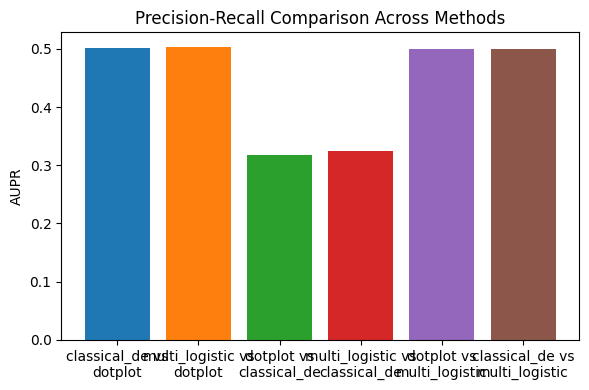

In [17]:
plt.figure(figsize=(6, 4))
for idx, row in aupr_table.iterrows():
    plt.bar(f"{row['Test']} vs\n{row['Truth']}", row['AUPR'])
plt.ylabel("AUPR")
plt.title("Precision-Recall Comparison Across Methods")
plt.tight_layout()
plt.show()


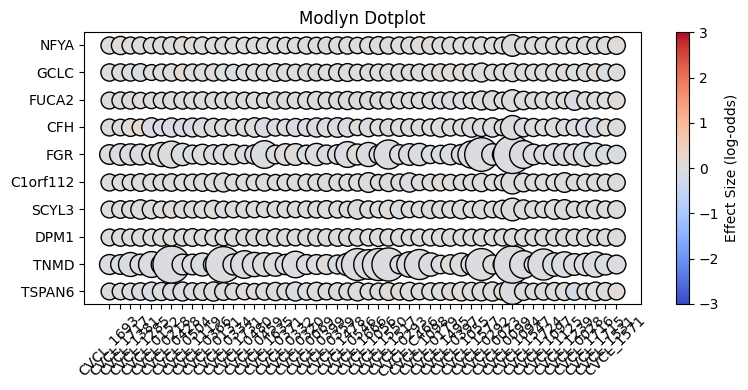

In [18]:
genes = adata.var_names[:10].tolist()
groups = adata.obs["cell_line"].astype(str).unique().tolist()
volcano_dotplot(effect_matrix=weights, se_matrix=se_matrix, genes=genes, groups=groups, title="Modlyn Dotplot")


In [19]:
spearman_effects = compute_rank_correlation(classical_de_scores, logistic_weights)
print(f"Spearman correlation (log2FC vs logistic weights): {spearman_effects:.3f}")


Spearman correlation (log2FC vs logistic weights): 0.008
